# Creating the stellar population using TRILEGAL sample and Mathur 2017 population. NB: Paths will need changing to operate this code. 

In [1]:
#Module imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import random
from itertools import repeat
from scipy import stats
import csv
import os
import seaborn as sns

Pulls the temperature, logg and magnitude from the Mathur 2017 catalog. Because the Kepler magnitude is not contained within the original Mathur catalog, they were downloaded from Simbad and opened separately. 

The files: 
1. mathur_2017_edited.txt contains the original Mathur catalog, with the preamble cut out. 
2. mathur_master.txt contains just the KIC ID's and the Kepler magnitudes for each star.
          
A length check is performed to make sure there are the same number of temperatures and magnitudes, assuring that the same amount of stars are accounted for in each list. 

Temperatures are logged to make them consistent with the TRILEGAL sample. The three arrays are then stacked into one big sample.

In [2]:
#Pull Mathur data for temp, logg and mag
mathur = pd.read_csv('/Users/Jess/SF_m_dwarfs/SF_mathur_magnitudes/complete_mathur_file.csv')
mathur_teff = mathur['teff']
mathur_teff = np.log10(mathur_teff) 
mathur_logg = mathur['logg']
mathur_mag = mathur['kep_mag']

#CHECK
print('The number of stars in the original Mathur file is: ' + str(len(mathur_teff)))
print('The number of stars in the file of magnitudes is: ' + str(len(mathur_mag)))

#Stacking them into one big sample
mathur_sample = np.vstack([mathur_teff, mathur_logg, mathur_mag]) 

The number of stars in the original Mathur file is: 197096
The number of stars in the file of magnitudes is: 197096


Bin numbers are chosen for each parameters. This is so that at the plotting phase it is easy to know which parameter is which. It will not effect the overall outcome. 

In this iteration 25 bins are chosen. But this can of course be altered as desired. Important to remember that increasing bins will massively increase computation time. 

Histograms are then computed to find the edges of bins in a given parameter range, this range can and should be edited to need. np.histogram is used as it will provide the histogram frequency values as well as the bin edge values. Edges of bins can then be used to find the center of bins. The ticks are formatted for the plots at this stage also. 

A multi-dimensional array is produced to hold the sum of each bin at the end of the calculation. By looping through each bin separately in a nested loop (eek.) then we can test each combination of values against the bin edges to find which bin they belong in. This is then cast to a boolean array. i.e. whether or not this specific set of parameters exists. If it does, then the numbers are saved in the final multi-dimensional array as a 1 or a 0 depending on the booolean outcome of the process. 

Collapse one of the axes at a time so that we are left with two parameters in the array. This allows for the plotting of two parameters at a time with a third density parameter. These can then be plotted through imshow as a check on where the stars fall. The brighter bins will contain more stars. This is where the ticks are utilized from the earlier value rounding. In the y and x ticks code, the first value specifies where the ticks will be placed and the second contains the tick labels. 

In [3]:
min_teff = min(mathur_teff)
max_teff = max(mathur_teff)
min_logg = min(mathur_logg)
max_logg = max(mathur_logg)
min_mag = min(mathur_mag)
max_mag = max(mathur_mag)

#Bins for the three parameters 
num_bins=27 #Bins for Teff (27)
num_bins_logg=20 #Bins for logg (20)
num_bins_mag=20 #Bins for mag (20)

In [4]:
#Histogram for teff
#Range set is for temperature
hist_teff, bin_edges_teff = np.histogram(mathur_teff, bins=num_bins, range=(min_teff, max_teff)) 
bin_centers_teff = ((bin_edges_teff[:-1] + bin_edges_teff[1:]) / 2) #Finding the centers of the bins
bin_centers_teff_ticks = [] 
#Formatting ticks for plots
for i in bin_centers_teff: 
    a = str(round(i, 2)) 
    bin_centers_teff_ticks.append(a) 

#Histogram for logg
hist_logg, bin_edges_logg = np.histogram(mathur_logg, bins=num_bins_logg, range=(min_logg, max_logg))
bin_centers_logg = ((bin_edges_logg[:-1] + bin_edges_logg[1:]) / 2)
bin_centers_logg_ticks = []
for i in bin_centers_logg:
    a = str(round(i, 2))
    bin_centers_logg_ticks.append(a)    
   
rows = zip(bin_edges_teff, bin_edges_logg)
header = ['bin_edges_teff', 'bin_edges_logg']
df = pd.DataFrame(rows, columns=header)
df.to_csv('/Users/Jess/SF_m_dwarfs/SF_data_files/bin_edges_trilegal_mathur_cut.csv', index=False)

#Histogram for mag
hist_mag, bin_edges_mag = np.histogram(mathur_mag, bins=num_bins_mag, range=(min_mag, max_mag))
bin_centers_mag = ((bin_edges_mag[:-1] + bin_edges_mag[1:]) / 2)
bin_centers_mag_ticks = []
for i in bin_centers_mag:
    a = str(round(i, 2))
    bin_centers_mag_ticks.append(a)

#Create an array to hold the sum in each bin at the end
N_sum_mathur = np.zeros((num_bins, num_bins_logg, num_bins_mag))

#Fill up them bins
for i in range(len(bin_edges_teff)-1): 
    for j in range(len(bin_edges_logg)-1): 
        for k in range(len(bin_edges_mag)-1): 
            boolean_array = (mathur_teff >= bin_edges_teff[i])*(mathur_teff <= bin_edges_teff[i+1])*(mathur_logg >= bin_edges_logg[j])*(mathur_logg <= bin_edges_logg[j+1])*(mathur_mag >= bin_edges_mag[k])*(mathur_mag <= bin_edges_mag[k+1])
            N_sum_mathur[i,j,k] = np.sum(boolean_array)

#Collapse the number of bins along each axis to create an array for two variables, and a third in density
N_temp_logg = np.sum(N_sum_mathur, axis=2) #temperature vs. logg
N_temp_mag = np.sum(N_sum_mathur, axis=1) #temperature vs. mag 
N_mag_logg = np.sum(N_sum_mathur, axis=0) #mag vs. logg

/opt/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/miniconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


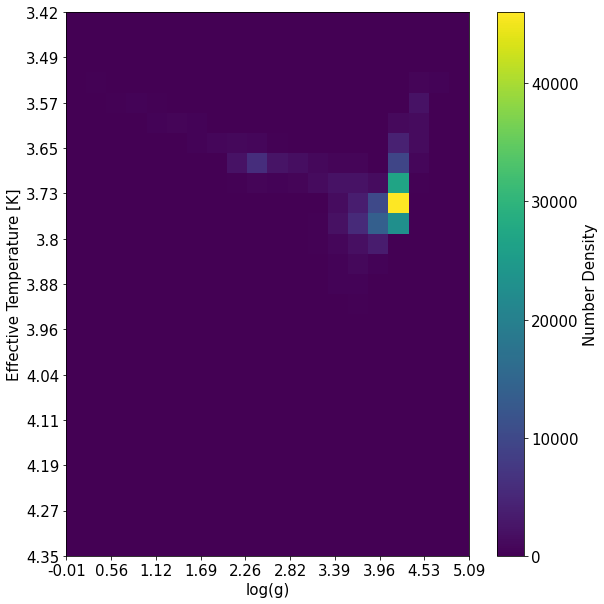

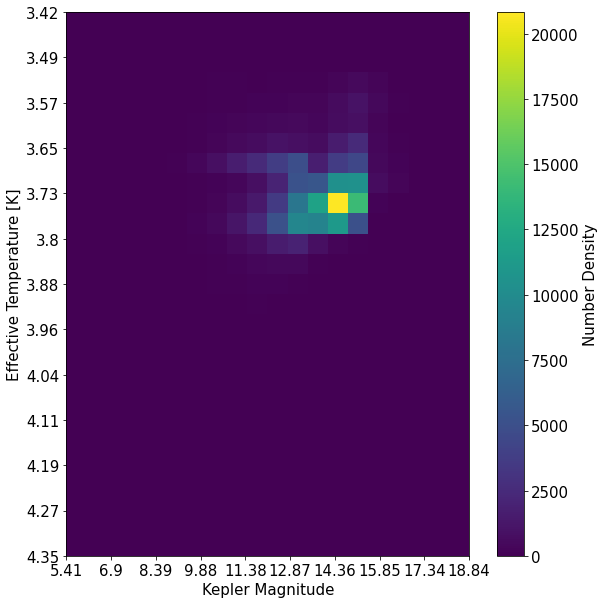

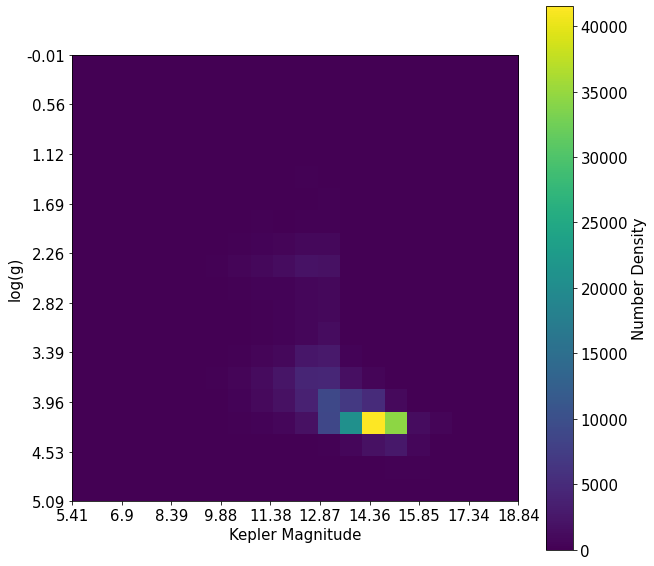

In [5]:
#Plotting 2D density plots
bin_centers_teff_ticks_half = []
a = 0
for i in bin_centers_teff_ticks:
    if int(a)%2 == 0:
        bin_centers_teff_ticks_half.append(i)
        a = a + 1
    else:
        a = a + 1
        
bin_centers_logg_ticks_half = []
a = 0
for i in bin_centers_logg_ticks:
    if int(a)%2 == 0:
        bin_centers_logg_ticks_half.append(i)
        a = a + 1
    else:
        a = a + 1
        
bin_centers_mags_ticks_half = []
a = 0
for i in bin_centers_mag_ticks:
    if int(a)%2 == 0:
        bin_centers_mags_ticks_half.append(i)
        a = a + 1
    else:
        a = a + 1
        
xticks_teff = np.linspace(0, num_bins, int(num_bins/2))
xticks_logg = np.linspace(0, num_bins_logg, int(num_bins_logg/2))
xticks_mag = np.linspace(0, num_bins_mag, int(num_bins_mag/2))

plt.figure(figsize=(10, 10))
plt.imshow(N_temp_logg)
plt.yticks(xticks_teff-0.5, bin_centers_teff_ticks_half)
plt.xticks(xticks_logg-0.5, bin_centers_logg_ticks_half)
plt.ylabel('Effective Temperature [K]' , fontsize=15) 
plt.xlabel('log(g)', fontsize=15) 
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Number Density', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('/Users/Jess/sf_m_dwarfs/sf_plots/P_mathur_bins_teff_logg.png')
plt.show()

plt.figure(figsize=(10, 10)) 
plt.imshow(N_temp_mag)
plt.yticks(xticks_teff-0.5, bin_centers_teff_ticks_half)
plt.xticks(xticks_mag-0.5, bin_centers_mags_ticks_half)
plt.ylabel('Effective Temperature [K]', fontsize=15)
plt.xlabel('Kepler Magnitude', fontsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Number Density', fontsize=15)
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15) 
plt.savefig('/Users/Jess/sf_m_dwarfs/sf_plots/P_mathur_bins_teff_mag.png')
plt.show()

plt.figure(figsize=(10, 10)) 
plt.imshow(N_mag_logg)
plt.yticks(xticks_logg-0.5, bin_centers_logg_ticks_half)
plt.xticks(xticks_mag-0.5, bin_centers_mags_ticks_half)
plt.xlabel('Kepler Magnitude', fontsize=15)
plt.ylabel('log(g)', fontsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Number Density', fontsize=15)
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15) 
plt.savefig('/Users/Jess/sf_m_dwarfs/sf_plots/P_mathur_bins_logg_mag.png')
plt.show()

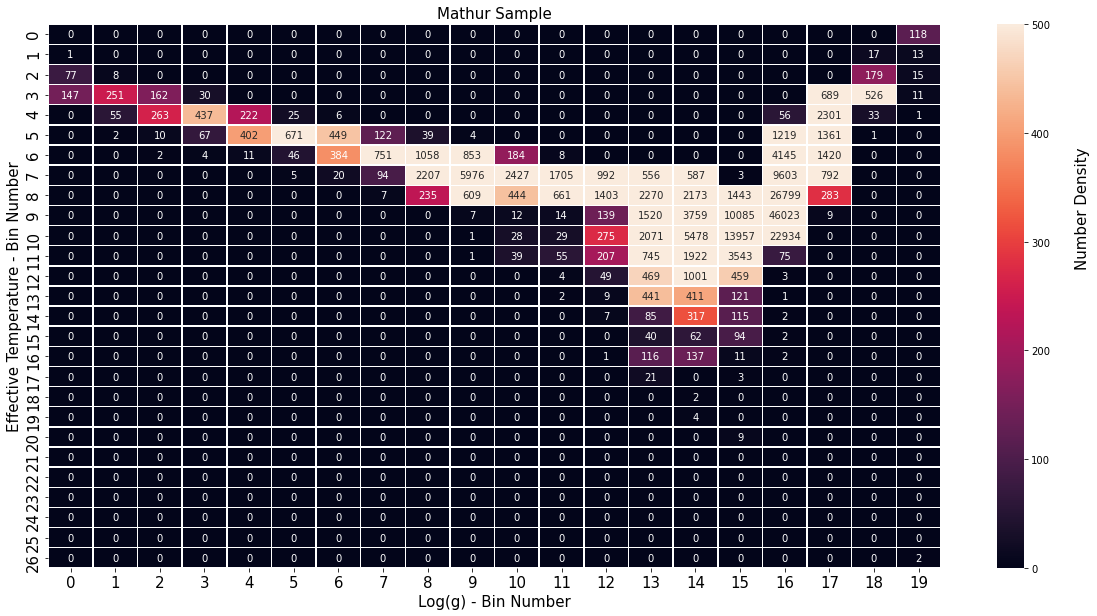

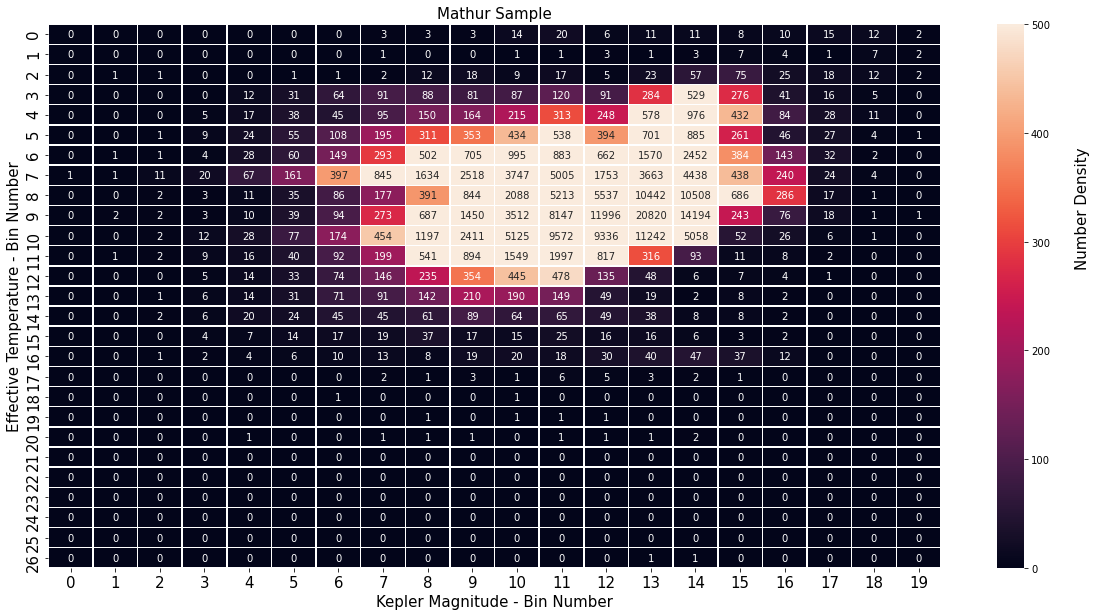

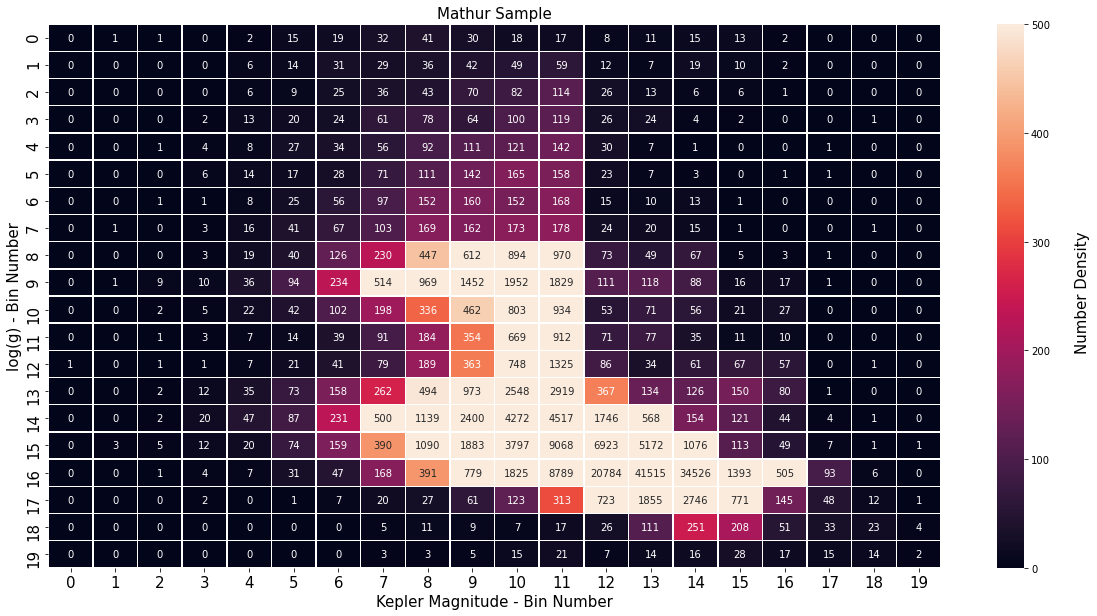

In [6]:
plt.figure(figsize=(20, 10))
ax = sns.heatmap(N_temp_logg, annot=True, fmt='g', cmap='rocket', vmax=500, linewidth=0.5)
plt.ylabel('Effective Temperature - Bin Number', fontsize=15)
plt.xlabel('Log(g) - Bin Number', fontsize=15)
plt.text(23, 12, 'Number Density', fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.title('Mathur Sample', fontsize=15)
plt.xticks(fontsize=15)
plt.savefig('/Users/jess/sf_m_dwarfs/sf_plots/P_temp_logg_bins.png')
plt.show()

plt.figure(figsize=(20, 10))
ax = sns.heatmap(N_temp_mag, annot=True, fmt='g', cmap='rocket', vmax=500, linewidth=0.5)
plt.ylabel('Effective Temperature - Bin Number', fontsize=15)
plt.xlabel('Kepler Magnitude - Bin Number', fontsize=15)
plt.text(23, 12, 'Number Density', fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.title('Mathur Sample', fontsize=15)
plt.xticks(fontsize=15)
plt.savefig('/Users/jess/sf_m_dwarfs/sf_plots/P_temp_mag_bins.png')
plt.show()

plt.figure(figsize=(20, 10))
ax = sns.heatmap(N_mag_logg, annot=True, fmt='g', cmap='rocket', vmax=500, linewidth=0.5)
plt.ylabel('log(g) - Bin Number', fontsize=15)
plt.xlabel('Kepler Magnitude - Bin Number', fontsize=15)
plt.text(23, 12, 'Number Density', fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.title('Mathur Sample', fontsize=15)
plt.xticks(fontsize=15)
plt.savefig('/Users/jess/sf_m_dwarfs/sf_plots/P_logg_mag_bins.png')
plt.show()

In this case the panda series do need to be converted to numpy arrays for the code to run efficiently.

The same process now happens for the TRILEGAL sample as did for the mathur sample above. This file has to be created by consolidating the TRILEGAL files on the Github and providing them with independant indexs. It is not available on the Git, due to size. 

The only difference to the Mathur code above is that a dictionary of values is created that correspond to each box that that they can be pulled later to create a new sample. 

In [7]:
#Pull TRILEGAL values
print('running') #Test print for long run

trilegal = pd.read_csv('/Users/Jess/SF_m_dwarfs/SF_trilegal_data/full_trilegal_sample_index.csv', delimiter=',')
trilegal_teff = trilegal['logTe']
trilegal_logg = trilegal['logg']
trilegal_mag = trilegal['Kepler']
trilegal_index = trilegal['index']

running


In [8]:
#Converting TRILGEAL data from pd series to arrays
trilegal_teff = np.array(trilegal_teff) 
trilegal_logg = np.array(trilegal_logg)
trilegal_mag = np.array(trilegal_mag) 
trilegal_index = np.array(trilegal_index)

In [9]:
#This is the same process as run for the Mathur sample above.
print('running') #Test print for long run

hist_teff, bin_edges_teff = np.histogram(trilegal_teff, bins=num_bins, range=(min_teff, max_teff))
bin_centers_teff = ((bin_edges_teff[:-1] + bin_edges_teff[1:]) / 2)
bin_centers_teff_ticks = []
for i in bin_centers_teff:
    a = str(round(i, 1))
    bin_centers_teff_ticks.append(a)

hist_logg, bin_edges_logg = np.histogram(trilegal_logg, bins=num_bins_logg, range=(min_logg, max_logg))
bin_centers_logg = ((bin_edges_logg[:-1] + bin_edges_logg[1:]) / 2)
bin_centers_logg_ticks = []
for i in bin_centers_logg:
    a = str(round(i, 1))
    bin_centers_logg_ticks.append(a)

hist_mag, bin_edges_mag = np.histogram(trilegal_mag, bins=num_bins_mag, range=(min_mag, max_mag))
bin_centers_mag = ((bin_edges_mag[:-1] + bin_edges_mag[1:]) / 2)
bin_centers_mag_ticks = []
for i in bin_centers_mag:
    a = str(round(i, 1))
    bin_centers_mag_ticks.append(a)
    
N_sum = np.zeros((num_bins, num_bins_logg, num_bins_mag))
star_dict = {} #Initiate dictionary 

for i in range(len(bin_edges_teff)-1):
    for j in range(len(bin_edges_logg)-1):
        for k in range(len(bin_edges_mag)-1):
            boolean_array = (trilegal_teff >= bin_edges_teff[i])*(trilegal_teff <= bin_edges_teff[i+1])*(trilegal_logg >= bin_edges_logg[j])*(trilegal_logg <= bin_edges_logg[j+1])*(trilegal_mag >= bin_edges_mag[k])*(trilegal_mag <= bin_edges_mag[k+1])
            N_sum[i,j,k] = np.sum(boolean_array)
            star_dict[(i,j,k)] = boolean_array 

N_temp_logg = np.sum(N_sum, axis=2)
N_temp_mag = np.sum(N_sum, axis=1)
N_logg_mag = np.sum(N_sum, axis=0)

running


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10


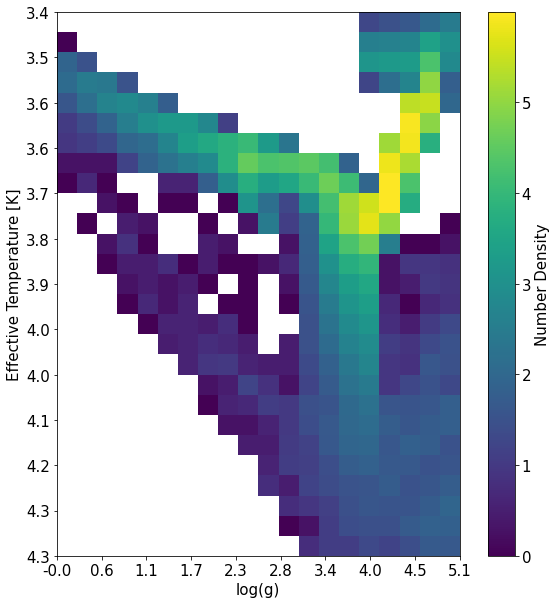

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10


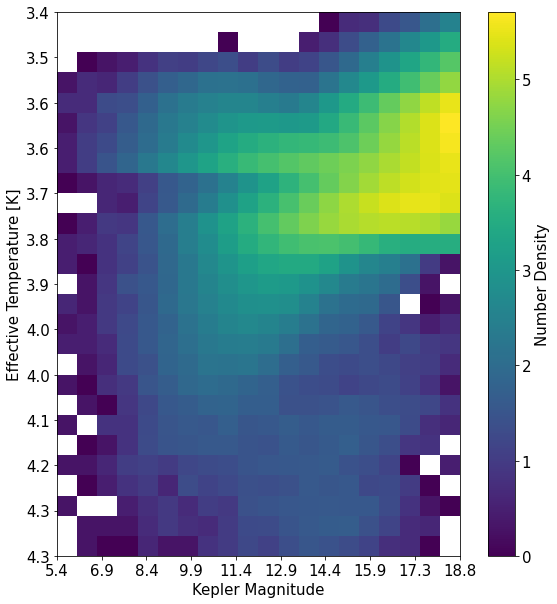

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log10


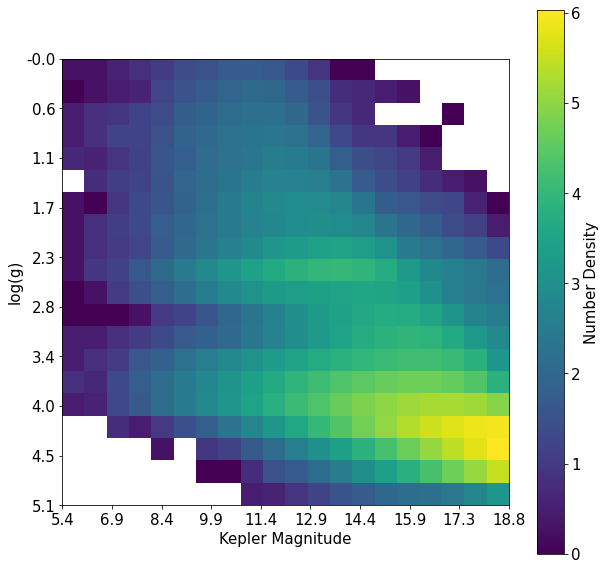

In [10]:
#Plotting 2D density plots
bin_centers_teff_ticks_half = []
a = 0
for i in bin_centers_teff_ticks:
    if int(a)%2 == 0:
        bin_centers_teff_ticks_half.append(i)
        a = a + 1
    else:
        a = a + 1
        
bin_centers_logg_ticks_half = []
a = 0
for i in bin_centers_logg_ticks:
    if int(a)%2 == 0:
        bin_centers_logg_ticks_half.append(i)
        a = a + 1
    else:
        a = a + 1
        
bin_centers_mags_ticks_half = []
a = 0
for i in bin_centers_mag_ticks:
    if int(a)%2 == 0:
        bin_centers_mags_ticks_half.append(i)
        a = a + 1
    else:
        a = a + 1
        
xticks_teff = np.linspace(0, num_bins, int(num_bins/2))
xticks_logg = np.linspace(0, num_bins_logg, int(num_bins_logg/2))
xticks_mag = np.linspace(0, num_bins_mag, int(num_bins_mag/2))

plt.figure(figsize=(10, 10))
plt.imshow(np.log10(N_temp_logg))
plt.yticks(xticks_teff-0.5, bin_centers_teff_ticks_half)
plt.xticks(xticks_logg-0.5, bin_centers_logg_ticks_half)
plt.ylabel('Effective Temperature [K]', fontsize=15)
plt.xlabel('log(g)', fontsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Number Density', fontsize=15)
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15) 
plt.savefig('/users/jess/sf_m_dwarfs/sf_plots/P_trilegal_bins_teff_logg.png')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(np.log10(N_temp_mag))
plt.yticks(xticks_teff-0.5, bin_centers_teff_ticks_half)
plt.xticks(xticks_mag-0.5, bin_centers_mags_ticks_half)
plt.ylabel('Effective Temperature [K]', fontsize=15)
plt.xlabel('Kepler Magnitude', fontsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Number Density', fontsize=15)
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)
plt.savefig('/users/jess/sf_m_dwarfs/sf_plots/P_trilegal_bins_teff_mag.png')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(np.log10(N_logg_mag))
plt.yticks(xticks_logg-0.5, bin_centers_logg_ticks_half)
plt.xticks(xticks_mag-0.5, bin_centers_mags_ticks_half)
plt.xlabel('Kepler Magnitude', fontsize=15)
plt.ylabel('log(g)', fontsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Number Density', fontsize=15)
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)
plt.savefig('/users/jess/sf_m_dwarfs/sf_plots/P_trilegal_bins_logg_mag.png')
plt.show()

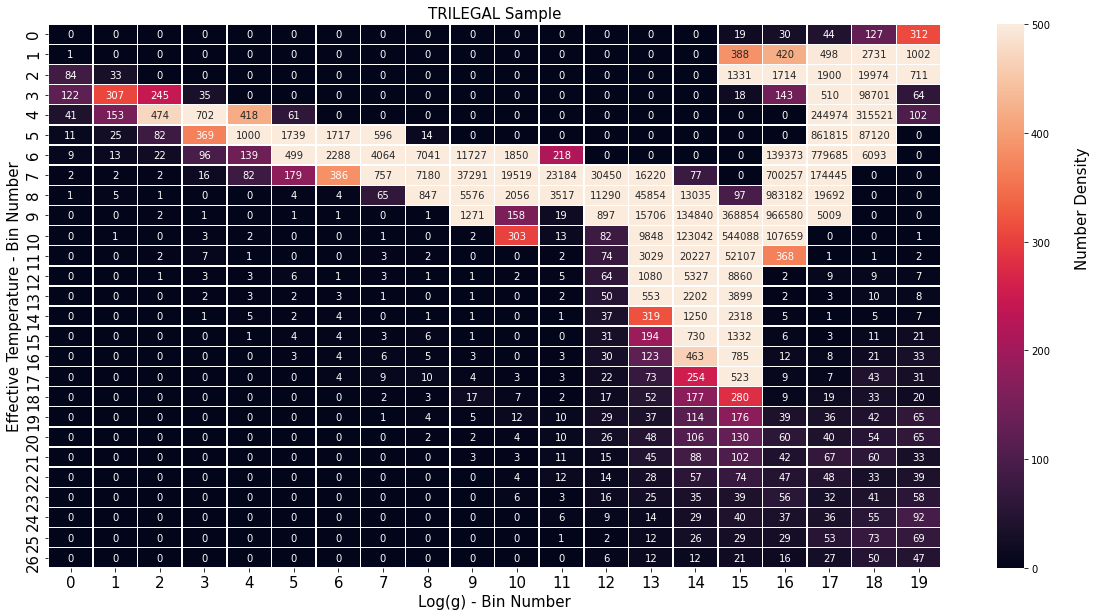

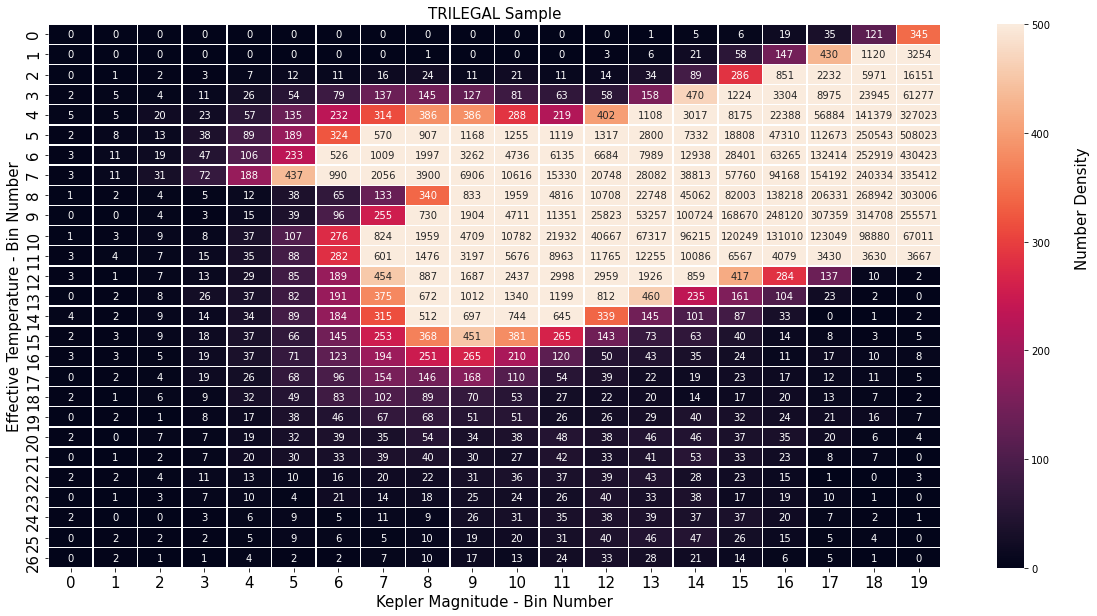

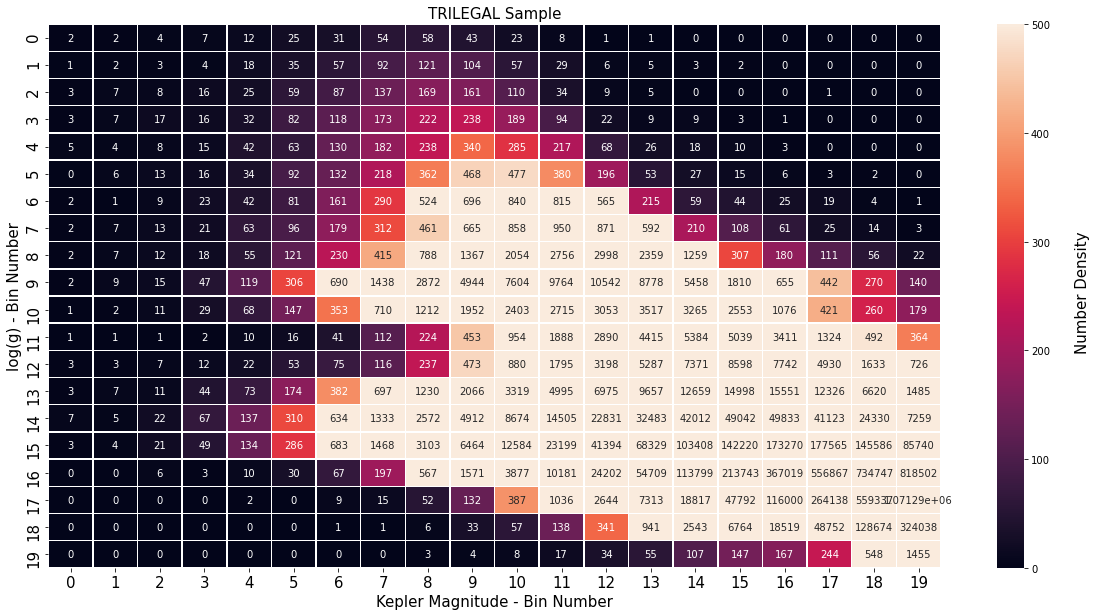

In [11]:
plt.figure(figsize=(20, 10))
ax = sns.heatmap(N_temp_logg, annot=True, fmt='g', cmap='rocket', vmax=500, linewidth=0.5)
plt.ylabel('Effective Temperature - Bin Number', fontsize=15)
plt.xlabel('Log(g) - Bin Number', fontsize=15)
plt.text(23, 12, 'Number Density', fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.title('TRILEGAL Sample', fontsize=15)
plt.xticks(fontsize=15)
plt.savefig('/Users/jess/sf_m_dwarfs/sf_plots/P_trilegal_temp_logg_bins.png')
plt.show()

plt.figure(figsize=(20, 10))
ax = sns.heatmap(N_temp_mag, annot=True, fmt='g', cmap='rocket', vmax=500, linewidth=0.5)
plt.ylabel('Effective Temperature - Bin Number', fontsize=15)
plt.xlabel('Kepler Magnitude - Bin Number', fontsize=15)
plt.text(23, 12, 'Number Density', fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.title('TRILEGAL Sample', fontsize=15)
plt.xticks(fontsize=15)
plt.savefig('/Users/jess/sf_m_dwarfs/sf_plots/P_trilegal_temp_mag_bins.png')
plt.show()

plt.figure(figsize=(20, 10))
ax = sns.heatmap(N_logg_mag, annot=True, fmt='g', cmap='rocket', vmax=500, linewidth=0.5)
plt.ylabel('log(g) - Bin Number', fontsize=15)
plt.xlabel('Kepler Magnitude - Bin Number', fontsize=15)
plt.text(23, 12, 'Number Density', fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.title('TRILEGAL Sample', fontsize=15)
plt.xticks(fontsize=15)
plt.savefig('/Users/jess/sf_m_dwarfs/sf_plots/P_trilegal_logg_mag_bins.png')
plt.show()

This part of the code uses the boolean arrays to read back in the values that the stars in each box will have and saved this back into a new file which contains the entire sample, matched to the Kepler sample. 

First, a new list is initiated for the indices of the stars which will be places in each bin. 

Then a for loop is used for each dimension in the multi-dimensional array, i.e. it runs through each 3D bin coordinate.

For each bin an if statement is run. If the number of stars in the bin is less than 1 for the Mathur sample this bin will be passed. Similarly for the TRILEGAL sample. This is ok as we would not expect the area we want to build a sample to be devoid of stars in our TRILEGAL model. 

If there are stars in both bins then the else function is run. First this will sort stars into two categories, those that have more stars in the Mathur catalog than in the TRILEGAL catalog (this would require some of the TRILEGAL stars to be repeated). The other category is when there are more stars in the TRILEGAL sample than the Mathur sample. This means there will be enough stars in the TRILEGAL sample to pick at random. Once the stars have been sorted into these two categories they are passed into the next if statement. 

The first part of the if statement asks if there are more stars in the TRILEGAL or Mathur bin. 
If there are more stars in the TRILEGAL bin then the right amount can be randomly chosen. These are added to the new total list of indices. The arg_in variable is used to randomly choose. 

The second part of the if statement will perform the same task for the indices, but for the case where there are more stars in the Mathur bin than the TRILEGAL bin. This code will chose the same star from the bin and repeat it as many times as necessary. These are then added to the final index list. 

In [12]:
print('running file creation') #Test print for long run 

#Initiating index list for values for new sample
trilegal_index_new = []
lost_list = []

#Count stars in bins and assign indices to them
for i in range(N_sum_mathur.shape[0]): 
    for j in range(N_sum_mathur.shape[1]): 
        for k in range(N_sum_mathur.shape[2]): 
            
            # If the number of stars in this Mathur bin == 0
            # Then ignore this bin 
            if N_sum_mathur[i,j,k] == 0:
                pass
            
            # If the number of stars in this TRILEGAL bin == 0 but there are stars in the Mathur bin
            # Do not equal 0, then run this loop.
            elif N_sum_mathur[i,j,k] >= 1 and N_sum[i,j,k] == 0: 
                with open('/users/jess/sf_m_dwarfs/sf_data_files/lost_list.txt', 'a') as f:
                    print('\nThere are ' + str(N_sum_mathur[i,j,k]) + ' stars in this bin', file=f)
                    print('Bin number: ' + str(i) + ',' + str(j) + ',' + str(k), file=f)
                    print('Teff = ' + str(mathur_teff[i]), file=f)
                    print('Log(g) = ' + str(mathur_logg[j]), file=f)
                    print('Kepler Magnitude = ' + str(mathur_mag[k]), file=f)
                lost_list.append(1)
                pass
            
            # Otherwise we have stars in both the Mathur bin and the TRILEGAL bin
            # So we are good to go
            else: 
                #print('The number of stars in the mathur bin is: ' + str(len(N_sum_mathur[i,j,k])))
                # Creating a star object out of the indices given to find it in a trilegal bin
                new_star = star_dict[(i,j,k)] 
                a = np.random.uniform(0, 1, int(N_sum_mathur[i,j,k])) 
                arg_in = np.argsort(a)
                
                # If the number of stars in the TRILEGAL bin is greater than or equal to
                # The number of stars in the Mathur bin 
                if N_sum[i,j,k] >= N_sum_mathur[i,j,k]:
                    
                    trilegal_index_new.append(list(trilegal_index[new_star][arg_in[:int(N_sum_mathur[i,j,k]+1)]]))
                    
                # If the number of stars in the TRILEGAL bin is less than 
                # The number of stars in the Mathur bin
                if N_sum[i,j,k] < N_sum_mathur[i,j,k]: 
                    
                    available_stars = trilegal_index[new_star]
                    chosen_stars = np.random.choice(available_stars, size=int(N_sum_mathur[i,j,k]), replace=True)
                    trilegal_index_new.append(list(chosen_stars))
                
#Print how many numbers of bins will be in the final sample
print("\nNumber of bins in the final sample: " + str(len(trilegal_index_new)))
print('There are ' + str(len(lost_list)) + ' stars on the lost list.')

running file creation

Number of bins in the final sample: 1063
There are 171 stars on the lost list.


These indices are then used to go back to the TRILEGAL sample and draw the rest of the parameters out. The TRILEGAL sample is opened and a new file is created where we want to put the final sample. 
Then the CSV writer writes out the headers and then every row into the file by mapping the indices and pulling the corresponding rows. Other code in this section tidies up the final file and outputs it to the users destination. One file will be made and destroyed when the correct file is made. 

In [13]:
import os
os.remove('/Users/Jess/SF_m_dwarfs/SF_trilegal_data/final_trilegal_master.csv') 

list_trilegal_index = []
for sublist in trilegal_index_new:
    for item in sublist: 
        list_trilegal_index.append(item)

#print(len(list_trilegal_index))
#Collect data for the new file from TRILEGAL, using the new index list
df = pd.read_csv('/Users/Jess/SF_m_dwarfs/SF_trilegal_data/full_trilegal_sample_index.csv')
with open('/Users/Jess/SF_m_dwarfs/SF_trilegal_data/final_trilegal_master.csv', 'a', newline='') as f_outputcsv: 
    csv_writer = csv.writer(f_outputcsv) 
    row_head = ['Index','Gc','logAge','[M/H]','m_ini','logL','logTe','logg','m-M0','Av','m2/m1','mbol','Kepler','g','r','i','z','DDO51_finf','J','H','Ks','Mact']
    csv_writer.writerow(row_head)
    for i in list_trilegal_index:  
        row = df.iloc[int(i)] 
        csv_writer.writerow(row) 

In [15]:
trilegal = pd.read_csv('/Users/Jess/SF_m_dwarfs/SF_trilegal_data/full_trilegal_sample_index.csv', delimiter=',')
trilegal_teff = trilegal['logTe']
trilegal_logg = trilegal['logg']
trilegal_mag = trilegal['Kepler']
trilegal_index = trilegal['index']

mathur = pd.read_csv('/Users/Jess/SF_m_dwarfs/SF_mathur_magnitudes/complete_mathur_file.csv')
mathur_teff = mathur['teff']
mathur_teff = np.log10(mathur_teff) 
mathur_logg = mathur['logg']
mathur_mag = mathur['kep_mag']

trilegal_new = pd.read_csv('/Users/Jess/SF_m_dwarfs/SF_trilegal_data/final_trilegal_master.csv')
list_trilegal_temps = list(trilegal_new['logTe'])
list_trilegal_logg = list(trilegal_new['logg'])
list_trilegal_mags = list(trilegal_new['Kepler'])

The final plot overplots the Mathur sample, the TRILEGAL sample and the sample the code has created to check the validity of the cut. 

running


/opt/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


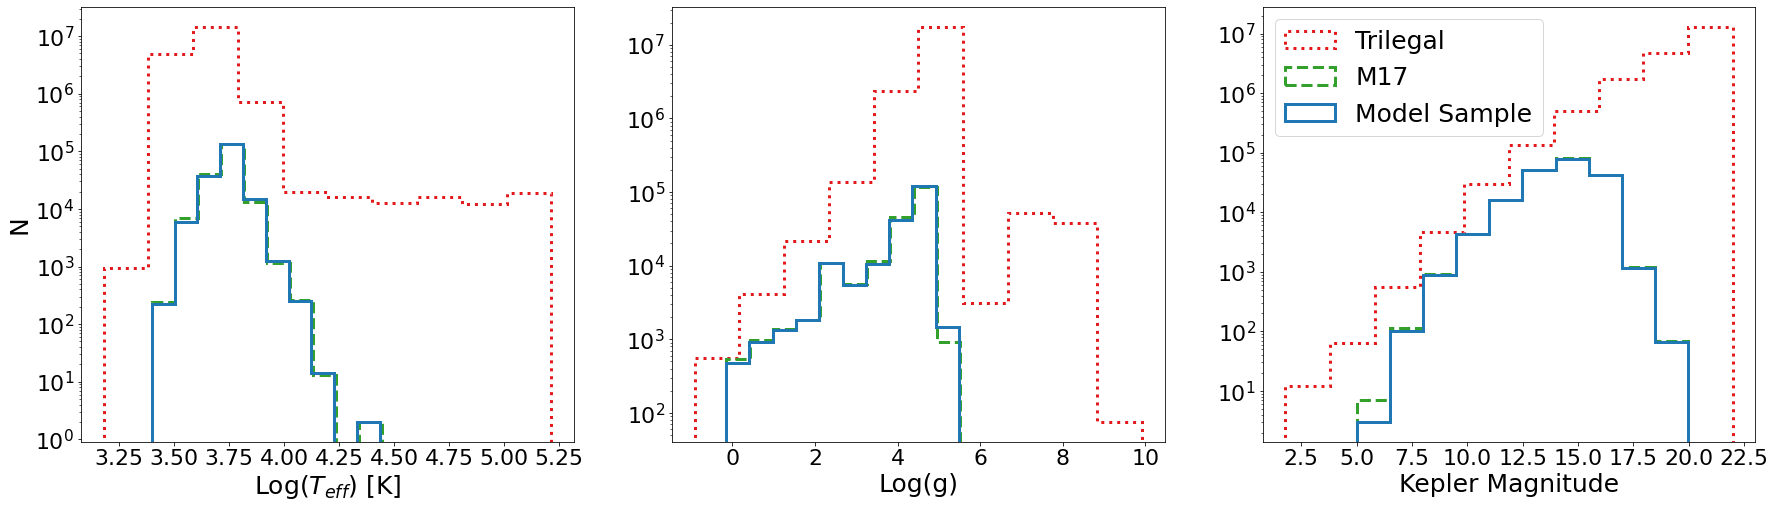

In [16]:
print('running')
#Overplotting original TRILEGAL sample, Mathur sample and new sample to make sure they agree
plt.figure(figsize=(30, 8)) #Set up figure 

#Histogram for effective temperature 
plt.subplot(131) #First subplot 
plt.hist(trilegal_teff, histtype='step', linestyle=':', color='#e31a1c', linewidth=3) #Plot original TRILEGAL teff
plt.hist(mathur_teff, histtype='step', linestyle='--', color='#33a02c', linewidth=3) #Plot Mathur teff
plt.hist(list_trilegal_temps, histtype='step', linestyle='-', color='#1f78b4', linewidth=3) #Plot new teff
plt.yscale('log') #Set log scale on y axis as number of stars in TRILEGAL sample much greater than Mathur sample
plt.xlabel(r'Log($T_{eff}$) [K]', fontsize=25) #Set x label 
plt.ylabel('N', fontsize=25) #Set y label
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

#Histogram from logg - see above 
plt.subplot(132)
plt.hist(trilegal_logg, histtype='step', linestyle=':', color='#e31a1c', linewidth=3)
plt.hist(mathur_logg, histtype='step', linestyle='--', color='#33a02c', linewidth=3)
plt.hist(list_trilegal_logg, histtype='step', linestyle='-', color='#1f78b4', linewidth=3)
plt.yscale('log')
plt.xlabel('Log(g)', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

#Histogram for Kepler magnitude - see above 
plt.subplot(133)
plt.hist(trilegal_mag, histtype='step', label='Trilegal', linestyle=':', color='#e31a1c', linewidth=3) #Set sample label 
#plt.hist(mathur_mag, range=(min(mathur_mag), max(mathur_mag)), histtype='step', label='M17', linestyle='--', color='#33a02c', linewidth=3) 
plt.hist(mathur_mag, histtype='step', label='M17', linestyle='--', color='#33a02c', linewidth=3) 
plt.hist(list_trilegal_mags, range=(min(mathur_mag), max(mathur_mag)), histtype='step', label='Model Sample', linestyle='-', color='#1f78b4', linewidth=3) #Set sample label 
plt.yscale('log')
plt.xlabel('Kepler Magnitude', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=25, loc=2) #Plot legend

#Save and show figure 
plt.savefig('/Users/Jess/SF_m_dwarfs/SF_plots/P_trilegal_mathur_comparison.png')
plt.show()